### THIS IS A NEW TEST - make a SED with a flux signal between 650-600nm only (zero elsewhere)

Same as chroma_test4 but use a SED with a single flux point at 650nm!

Try to compute DCR for a given SED.

Use a SED from the sims package. Note here we just use the sims package to define the catalog directory and wrap it with chroma.spec.sed -- this is slow.

First need to do:

```
setup -t b1740 sims_sed_library
setup -t b1740 throughputs
```

In [7]:
import os
import numpy as np

import dcr
import spec    ## dont forget to add $HOME/GIT_REPOS/chroma/chroma to PYTHONPATH before starting ipython notebook
#import plot
#import utils

#import _mypath
#import chroma

#bpDir = '/Users/dreiss/GIT_REPOS/chroma/data/filters/'
#bpDir = '/Users/dreiss/lsstsw/stack/DarwinX86/throughputs/master-ga98b3deed1/baseline/'
bpDir = os.environ['LSST_THROUGHPUTS_DEFAULT']
catDir = os.environ['SIMS_SED_LIBRARY_DIR']

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

## see http://matplotlib.org/users/colormaps.html for colormaps
from matplotlib import cm

In [8]:
import pandas as pd

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

Looks like chroma.spec has a few useful functions like 

```
calculateDCRMomentShifts(self, bandpass, **kwargs):
```

        @returns a tuple.  The first element is the vector of DCR first moment shifts, and the
                 second element is the 2x2 matrix of DCR second (central) moment shifts.


Use same stellar spectrum as S14 study, to start...

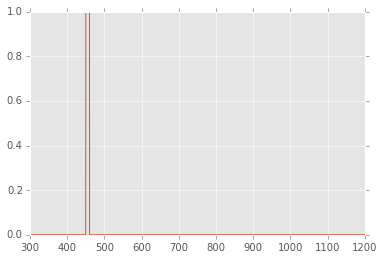

In [21]:
from scipy.interpolate import interp1d

star_SEDname = "delta450nm.ascii"
w,f = np.genfromtxt(star_SEDname).T
ss = interp1d(w, f)

SED = spec.SED(ss) ##.atRedshift(0.5)
#wave = np.arange(500.0, 901.0, 1.0)
#photons = SED(wave)

#scale = 1.2 * photons[(wave > 500) & (wave < 1000)].max()
#plt.plot(wave, photons/scale)
plt.plot(w,f)

Make a relative DCR curve for 'star' (assume ZD angle 20 deg.)

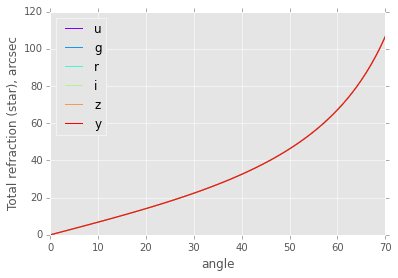

In [26]:
# filters are stored in two columns: wavelength (nm), and throughput

def compute_dcr(SED, filters='ugrizy', angles=np.linspace(0,70,14), relative=None, **kwargs):
    if type(angles) is int or type(angles) is float:
        angles = np.array([angles])
    elif type(angles) is list:
        angles = np.array(angles)        
    if type(filters) is int or type(filters) is float:
        filters = np.array([filters])
    df = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
    for i, filter_ in enumerate(filters):
        if type(filter_) is str:
            fdata = spec.Bandpass(bpDir+'/filter_{}.dat'.format(filter_))
            fwave, throughput = fdata.wave_list, fdata(fdata.wave_list)
            shifts = np.array( [SED.calculateDCRMomentShifts(fdata, zenith_angle=angle * np.pi/180.0, **kwargs)[0].item(1) 
                            for angle in angles])
            shifts = shifts * 3600.0 * 180.0/np.pi            
            df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
        else: # assume it's a single wavelength value (nm) then
            shifts = np.array( [dcr.get_refraction(filter_, zenith=angle * np.pi/180.0, **kwargs) for angle in angles])
            shifts = shifts * 3600.0 * 180.0/np.pi            
            df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
             
    df.columns = np.insert(np.array(list(filters), dtype='S6'), 0, 'angle')
    df = df.set_index('angle')
    if relative is not None and np.any(df.columns.values == relative):
        df2 = df.copy().sub(df[relative], axis=0)
        return df2
    else:
        return df

angles = np.linspace(0,70,71)

DCRs = compute_dcr(SED, 'ugrizy', angles)

import pickle
pickle.dump(DCRs, open( "save.p", "wb" ))

ax = DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction (star), arcsec')

#DCRs = compute_dcr(sn_SED, 'ugrizy', angles, relative='r')
#ax = DCRs.plot(colormap=cm.rainbow)
#ax.set_ylabel('Relative refraction, arcsec')

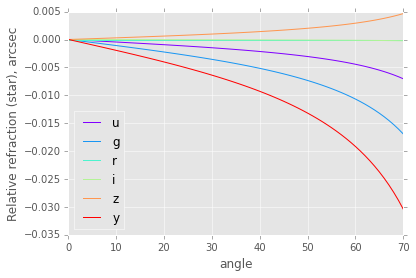

In [27]:
DCRs = compute_dcr(SED, 'ugrizy', angles, relative='r')
ax = DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (star), arcsec')

#DCRs_gal = compute_dcr(gal_SED, 'ugrizy', angles, relative='r')
#ax = DCRs_gal.plot(colormap=cm.rainbow)
#ax.set_ylabel('Relative refraction, arcsec')

In [28]:
sizeme(DCRs.tail())

,u,g,r,i,z,y
angle,,,,,,
66,-0.005753,-0.013841,0,-0.000183,0.003794,-0.024859
67,-0.006034,-0.014517,0,-0.000192,0.003980,-0.026074
68,-0.006339,-0.015252,0,-0.000201,0.004181,-0.027394
69,-0.006672,-0.016053,0,-0.000212,0.004401,-0.028832
70,-0.007037,-0.016931,0,-0.000224,0.004641,-0.030408
